In [ ]:
#| default_exp utils

# Utils

In [ ]:
#| export
import logging
import os
import sys
import tqdm
import torch
import time
import platform
import psutil

import importlib.metadata

import itertools

import pandas as pd
import numpy as np

import peptdeep

In [ ]:
#| export

BASE_PATH = os.path.expanduser('~/peptdeep')
LOG_PATH = os.path.join(BASE_PATH, "logs")

# from alphatims
def process_bar(iterator, len_iter):
    with tqdm.tqdm(total=len_iter) as bar:
        i = 0
        for i,iter in enumerate(iterator):
            yield iter
            bar.update()
        bar.update(len_iter-i-1)

log_level_dict = {
    'debug': logging.DEBUG,
    'info': logging.INFO,
    'warning': logging.WARNING,
    'error': logging.ERROR,
    'critical': logging.CRITICAL,
}

def set_logger(
    *,
    log_file_name="",
    stream: bool = True,
    log_level: str = 'info',
    overwrite: bool = False,
) -> str:
    """Set the log stream and file.
    All previously set handlers will be disabled with this command.

    Parameters
    ----------
    log_file_name : str, None
        The file name to where the log is written.
        Folders are automatically created if needed.
        This is relative to the current path. When an empty string is provided,
        a log is written to the AlphaTims "logs" folder with the name
        "log_yymmddhhmmss" (reversed timestamp year to seconds).
        If None, no log file is saved.
        Default is "".

    stream : bool
        If False, no log data is sent to stream.
        If True, all logging can be tracked with stdout stream.
        Default is True.

    log_level : str or int
        The logging level. Usable values are defined in Python's "logging"
        module. Could be: 'debug', 'info', 'warning', 'error', 'critical'.
        See `log_level_dict`. 
        Default is 'info'.

    overwrite : bool
        If True, overwrite the log_file if one exists.
        If False, append to this log file.
        Default is False.

    Returns
    -------
    str
        The file name to where the log is written.
    """
    if isinstance(log_level, str):
        if log_level.lower() in log_level_dict:
            log_level = log_level_dict[log_level.lower()]
        else:
            log_level = logging.INFO
    
    root = logging.getLogger()
    formatter = logging.Formatter(
        '%(asctime)s> %(message)s', "%Y-%m-%d %H:%M:%S"
    )
    root.setLevel(log_level)
    while root.hasHandlers():
        root.removeHandler(root.handlers[0])
    if stream:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(log_level)
        stream_handler.setFormatter(formatter)
        root.addHandler(stream_handler)
    if log_file_name is not None:
        if log_file_name == "":
            if not os.path.exists(LOG_PATH):
                os.makedirs(LOG_PATH)
            log_file_name = LOG_PATH
        log_file_name = os.path.abspath(log_file_name)
        if os.path.isdir(log_file_name):
            current_time = time.localtime()
            current_time = "".join(
                [
                    f'{current_time.tm_year:04}',
                    f'{current_time.tm_mon:02}',
                    f'{current_time.tm_mday:02}',
                    f'{current_time.tm_hour:02}',
                    f'{current_time.tm_min:02}',
                    f'{current_time.tm_sec:02}',
                ]
            )
            log_file_name = os.path.join(
                log_file_name,
                f"log_{current_time}.txt"
            )
        directory = os.path.dirname(log_file_name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        if overwrite:
            file_handler = logging.FileHandler(log_file_name, mode="w")
        else:
            file_handler = logging.FileHandler(log_file_name, mode="a")
        file_handler.setLevel(log_level)
        file_handler.setFormatter(formatter)
        root.addHandler(file_handler)
    return log_file_name
set_logger(log_file_name=None)

def show_platform_info() -> None:
    """Log all platform information.
    This is done in the following format:
    ```
        - [timestamp]> Platform information:
        - [timestamp]> system         - [...]
        - [timestamp]> release        - [...]
        - [timestamp]> version        - [...]
        - [timestamp]> machine        - [...]
        - [timestamp]> processor      - [...]
        - [timestamp]> cpu count      - [...]
        - [timestamp]> cpu frequency  - [...]
        - [timestamp]> ram            - [...]/[...] Gb (available/total)
    ```
    """
    logging.info("Platform information:")
    logging.info(f"system        - {platform.system()}")
    logging.info(f"release       - {platform.release()}")
    if platform.system() == "Darwin":
        logging.info(f"version       - {platform.mac_ver()[0]}")
    else:
        logging.info(f"version       - {platform.version()}")
    logging.info(f"machine       - {platform.machine()}")
    logging.info(f"processor     - {platform.processor()}")
    logging.info(
        f"cpu count     - {psutil.cpu_count()}"
        # f" ({100 - psutil.cpu_percent()}% unused)"
    )
    logging.info(f"cpu frequency - {psutil.cpu_freq().current:.2f} Mhz")
    logging.info(
        f"ram           - "
        f"{psutil.virtual_memory().available/1024**3:.1f}/"
        f"{psutil.virtual_memory().total/1024**3:.1f} Gb "
        f"(available/total)"
    )
    logging.info("")


def show_python_info() -> None:
    """Log all Python information.
    This is done in the following format:
    ```
        - [timestamp]> Python information:
        - [timestamp]> alphatims          - [current_version]
        - [timestamp]> [required package] - [current_version]
        - ...
        - [timestamp]> [required package] - [current_version]
    ```
    """
    module_versions = {
        "python": platform.python_version(),
        "peptdeep": peptdeep.__version__
    }
    requirements = importlib.metadata.requires("peptdeep")
    for requirement in requirements:
        parts = requirement.split(";")
        if len(parts) > 1:
            if "development" in parts[1]:
                continue
            if "win32" in parts[1]:
                continue
        module_name = parts[0].split("=")[0].split()[0]
        try:
            module_version = importlib.metadata.version(module_name)
        except importlib.metadata.PackageNotFoundError:
            module_version = ""
        module_versions[module_name] = module_version
    max_len = max(len(key) for key in module_versions)
    logging.info("Python information:")
    for key, value in sorted(module_versions.items()):
        logging.info(f"{key:<{max_len}} - {value}")
    logging.info("")

In [ ]:
#| export
def parse_ms_file_names_to_dict(
    ms_file_list:list
)->dict:
    """
    Load spectrum file paths into a dict:
        "/Users/xxx/raw_name.raw" -> {"raw_name":"/Users/xxx/raw_name.raw"}

    Parameters
    ----------
    spectrum_file_list : list
        File path list

    Returns
    -------
    dict
        {"raw_name":"/Users/xxx/raw_name.raw", ...}
    """

    spec_dict = {}
    for ms_file in ms_file_list:
        raw_name = os.path.basename(ms_file)
        if raw_name.endswith('.ms_data.hdf'):
            raw_name = raw_name[:-len('.ms_data.hdf')]
        else:
            raw_name = os.path.splitext(raw_name)[0]
        spec_dict[raw_name] = ms_file
    return spec_dict

In [ ]:
#| hide
show_python_info()
show_platform_info()

2022-09-07 17:10:55> Python information:
2022-09-07 17:10:55> alphabase    - 0.1.3
2022-09-07 17:10:55> biopython    - 1.78
2022-09-07 17:10:55> click        - 7.1.2
2022-09-07 17:10:55> lxml         - 4.6.2
2022-09-07 17:10:55> numba        - 0.54.0
2022-09-07 17:10:55> numpy        - 1.19.4
2022-09-07 17:10:55> pandas       - 1.3.5
2022-09-07 17:10:55> peptdeep     - 0.1.5
2022-09-07 17:10:55> psutil       - 5.8.0
2022-09-07 17:10:55> python       - 3.8.3
2022-09-07 17:10:55> regex        - 2020.6.8
2022-09-07 17:10:55> scikit-learn - 1.1.1
2022-09-07 17:10:55> streamlit    - 1.12.2
2022-09-07 17:10:55> torch        - 1.7.1
2022-09-07 17:10:55> tqdm         - 4.56.0
2022-09-07 17:10:55> transformers - 4.16.1
2022-09-07 17:10:55> 
2022-09-07 17:10:55> Platform information:
2022-09-07 17:10:55> system        - Darwin
2022-09-07 17:10:55> release       - 20.6.0
2022-09-07 17:10:55> version       - 10.16
2022-09-07 17:10:55> machine       - x86_64
2022-09-07 17:10:55> processor     - i38

In [ ]:
#| export

def _flatten(list_of_lists):
    '''
    Flatten a list of lists
    '''
    return list(
        itertools.chain.from_iterable(list_of_lists)
    )

def explode_multiple_columns(df:pd.DataFrame, columns:list):
    try:
        return df.explode(columns)
    except ValueError:
        # pandas <= 1.2.x?
        logging.warn(f'pandas=={pd.__version__} cannot explode multiple columns')
        ret_df = df.explode(columns[0])
        for col in columns[1:]:
            ret_df[col] = _flatten(df[col].values)
        return ret_df


In [ ]:
#| export

def _is_mps_available()->bool:
    try:
        return torch.backends.mps.is_available()
    except AttributeError:
        print("Mac M1 chip ('mps') is not supported yet in pytorch")
        return False

torch_devices:dict = {
    'gpu': {
        'is_available': torch.cuda.is_available, 
        'device': 'cuda',
    },
    'cuda': {
        'is_available': torch.cuda.is_available, 
        'device': 'cuda',
    },
    'mps': {
        'is_available': _is_mps_available, 
        'device': 'mps',
    }
}

### Supported devices in peptdeep

In [ ]:
torch_devices

{'gpu': {'is_available': <function torch.cuda.is_available() -> bool>,
  'device': 'cuda'},
 'cuda': {'is_available': <function torch.cuda.is_available() -> bool>,
  'device': 'cuda'},
 'mps': {'is_available': <function __main__._is_mps_available() -> bool>,
  'device': 'mps'}}

In [ ]:
#| export

def regional_sampling(psm_df:pd.DataFrame,
    target:str='rt_norm', n_train:int=1000,
    return_test_df:bool=False,
    random_state:int=1337,
)->pd.DataFrame:
    """ Divide `psm_df` into 10 bins and sample training values
    from each bins for model fine-tuning. The values are defined in the `target`
    column (`rt_norm` or `ccs`).

    Parameters
    ----------
    psm_df : pd.DataFrame
        Dataframe of PSMs.

    target : str, optional
        Target columns to sample.
        Defaults to 'rt_norm'.

    n_train : int, optional
        The number of training PSMs to sample. 
        Defaults to 1000.

    return_test_df : bool, optional
        If also return `test_df`.
        `test_df` contains the PSMs that are not sampled.
        Defaults to False.

    random_state : int
        `random_state` in `df.sample()`.

    Returns
    -------
    pd.DataFrame or tuple of pd.DataFrame
        The sampled training PSMs (DataFrame)
        Additional [pd.DataFrame] is returned if `return_test_df==True` for PSMs not sampled.
    """
    x = np.arange(0, 11)/10*psm_df[target].max()
    sub_n = n_train//(len(x)-1)
    df_list = []
    for i in range(len(x)-1):
        _df = psm_df[
            (psm_df[target]>=x[i])&(psm_df[target]<x[i+1])
        ]
        if len(_df) == 0: pass
        elif len(_df)//2 < sub_n:
            df_list.append(_df.sample(
                len(_df)//2,
                replace=False,
                random_state=random_state
            ))
        else:
            df_list.append(_df.sample(
                sub_n,
                replace=False,
                random_state=random_state
            ))
    if return_test_df:
        if len(df_list) == 0:
            return pd.DataFrame(), pd.DataFrame()
        train_df = pd.concat(df_list)
        test_df = psm_df.drop(train_df.index)
        return train_df, test_df
    else:
        if len(df_list) == 0:
            return pd.DataFrame()
        return pd.concat(df_list)

#legacy
uniform_sampling = regional_sampling

## Plotting functions

In [ ]:
#| export

def evaluate_linear_regression(
    df:pd.DataFrame, x='rt_pred', y='rt_norm', 
    ci=95, n_sample=10000000
):
    import statsmodels.api as sm
    if len(df) > n_sample:
        df = df.sample(n_sample, replace=False)
    gls = sm.GLS(df[y], sm.add_constant(df[x]))
    res = gls.fit()
    summary = res.summary(alpha=1-ci/100.0)
    dfs = []
    results_as_html = summary.tables[0].as_html()
    dfs.append(pd.read_html(results_as_html, index_col=None)[0])
    results_as_html = summary.tables[1].as_html()
    dfs.append(pd.read_html(results_as_html, index_col=None)[0])
    summary = pd.concat(dfs, ignore_index=True)
    R_square = float(summary.loc[0,3])
    R = np.sqrt(R_square)
    n,b,w = summary.loc[[5,10,11],1].values.astype(float)
    return pd.DataFrame(
        dict(
            R_square=[R_square],R=[R],
            slope=[w],intercept=[b],test_num=[n]
        )
    )

def evaluate_linear_regression_plot(
    df:pd.DataFrame, x='rt_pred', y='rt_norm', 
    ci=95, n_sample=100000
):

    import seaborn as sns
    if len(df) > n_sample:
        df = df.sample(n_sample)
    alpha = 0.05
    if len(df) < 5000:
        alpha = 1
    elif len(df) < 50000:
        alpha = 5000.0/len(df)
    return sns.regplot(
        data=df, x=x, y=y, color='r', ci=ci, 
        scatter_kws={'s':0.05, 'alpha':alpha, 'color':'b'}
    )

<AxesSubplot:xlabel='rt_pred', ylabel='rt_norm'>

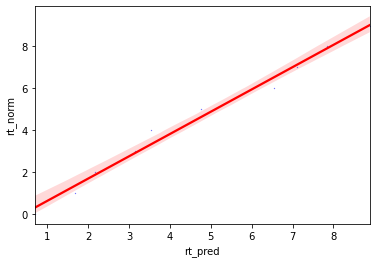

In [ ]:
#| hide
df = pd.DataFrame({'rt_norm':np.arange(10), 'rt_pred':np.arange(10)+np.random.normal(0,0.3,10)})
evaluate_linear_regression_plot(df)